# Testing the occultence package

In [1]:
from occultence import *

Generate (fake) lightcurve:

In [2]:
t = np.linspace(0.5,0.9,200)
ferr = 1e-3 * np.ones(len(t))
f = 1 + (ferr * (np.random.randn(len(t))))
f[22] = 1.01 # add a cosmic
f[63] = 1.008 # add a cosmic
f[50] = 0.0 # add a zero flux point

## Create LightCurve object

In [3]:
targ = LightCurve(name = "test",
                  time = t,
                  flux = f,
                  uncertainty = np.abs(ferr))

🌈🤖 Warning! The time array is not an astropy.Time object, therefore there is no info about the 
format or scale.
We will assume that it is JD and TDB from here on!



In [4]:
targ

<🌟 Lightcurve test (200t) 🌟>

In [5]:
# targ.__dict__

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='Time [d]', ylabel='Flux'>

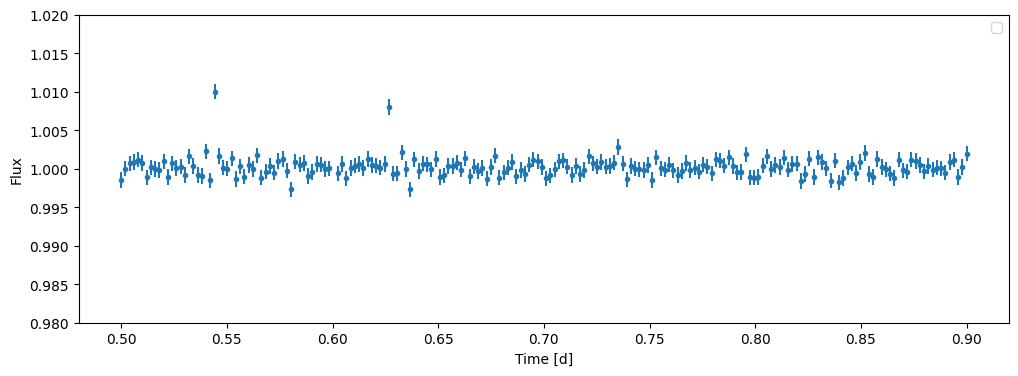

In [6]:
targ.plot()

## Clean LightCurve

In [7]:
clean_targ = targ.clean(dust_removal=False, bad_weather_removal=True, cosmics_removal=True, cosmic_boxsize=0.08, cosmic_nsigma=3)

/Users/catrionamurray/Library/CloudStorage/OneDrive-UCB-O365/PycharmProjects/occultence/occultence/cleaning/clean.py:73: UserWarning:  The LightCurve's timelike dictionary does not appear to have the 'artifical_lightcurve' in it.
                 This array is necessary to calculate bad weather, therefore this will ** not ** be applied!
  warnings.warn(f""" The LightCurve's timelike dictionary does not appear to have the 'artifical_lightcurve' in it.


Masking NaN fluxes...
Masking zero fluxes...
Masking bad weather...
Masking cosmic ray hits...


In [8]:
# targ.masks

In [9]:
bin_targ = clean_targ.bin(dt= 20 * u.minute)

<Axes: xlabel='Time [d]', ylabel='Flux'>

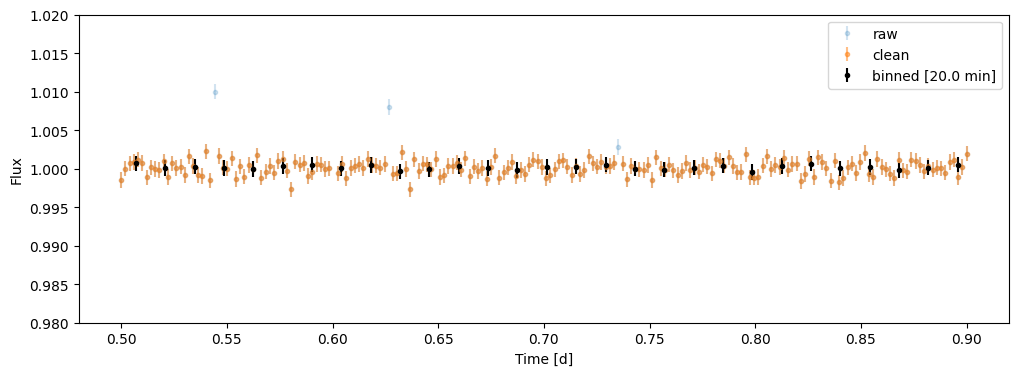

In [10]:
ax = targ.plot(alpha=0.2
               , label='raw')
ax = clean_targ.plot(ax=ax, alpha=0.5, label="clean")
bin_targ.plot(ax=ax, label=f"binned [{bin_targ.time_bin_size[0]}]", c='k')

/Users/catrionamurray/anaconda3/envs/occultence/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Fitting rotation with square-exponential GP...
Initial Parameter Vector:  [-6.90775528 -8.32325944 -0.69314718]
Initial Params: AMP =  0.0002428031696867766 , SQEXP=  0.5 , JITTER =  0.0010000000000000002
Initial ln-likelihood: 64.84
Fitted GP HPs: [-41.93851562 -27.20587255   5.43457127]
Fitted Params: AMP =  1.529817685493203e-12 , SQEXP=  229.194565068267 , JITTER =  6.114121796678756e-19
Final ln-likelihood: 154.58


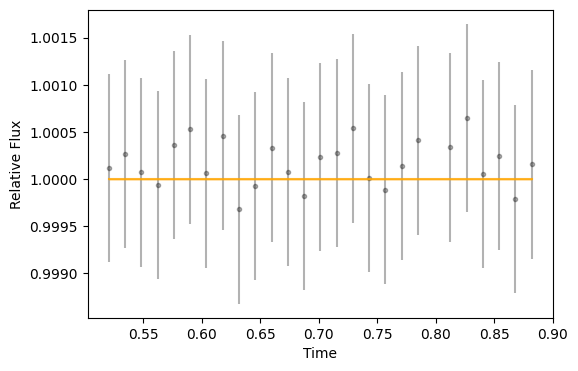

In [11]:
gp_targ = bin_targ.gp_detrend(do_first_sigma_clip=True, do_second_sigma_clip=True, nsigma=3)

Running BLS Search
Number of Periods Checked:  10000


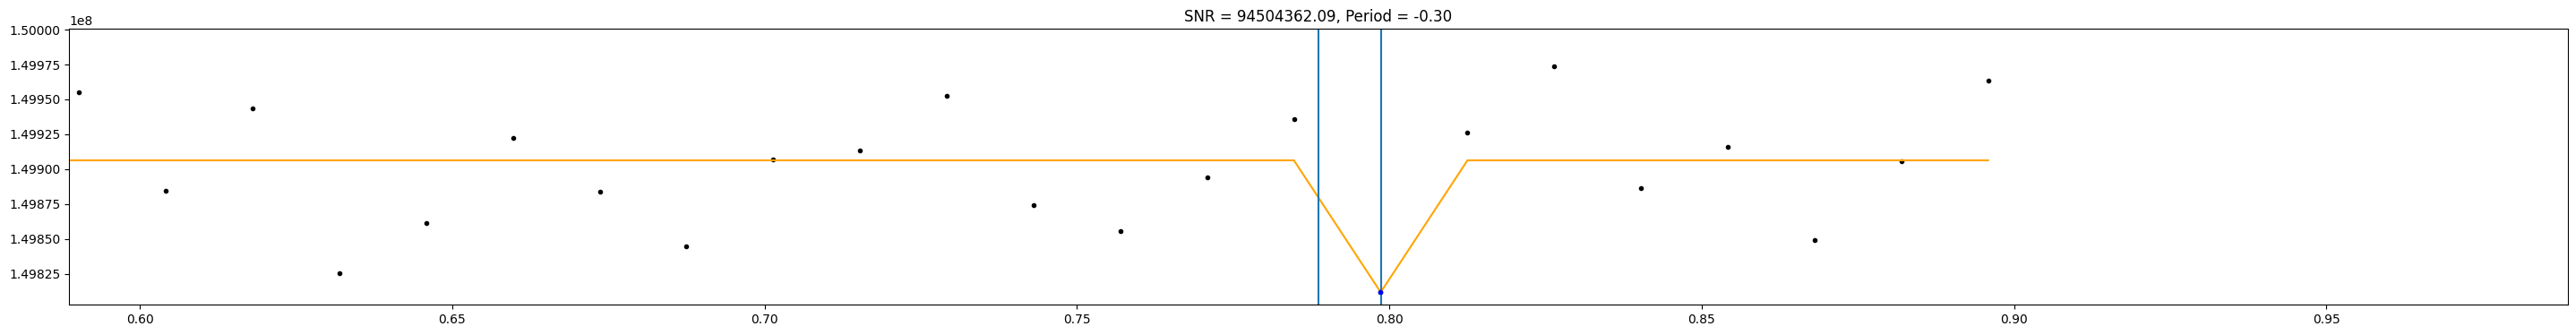

In [12]:
bls_targ = gp_targ.find_transits(minimum_period=0.5, maximum_period=10, transit_durations=[0.01, 0.02, 0.03])

In [15]:
gp_targ.flux

array([1.49991492e+08, 1.49900354e+08, 1.49921132e+08, 1.49890466e+08,
       1.49869124e+08, 1.49931165e+08, 1.49955194e+08, 1.49884291e+08,
       1.49943253e+08, 1.49825312e+08, 1.49861644e+08, 1.49922557e+08,
       1.49883612e+08, 1.49844731e+08, 1.49906729e+08, 1.49913228e+08,
       1.49952737e+08, 1.49874066e+08, 1.49855949e+08, 1.49893860e+08,
       1.49935740e+08, 1.49811816e+08, 1.49926244e+08, 1.49973867e+08,
       1.49886296e+08, 1.49916076e+08, 1.49849066e+08, 1.49905578e+08,
       1.49963216e+08])

In [13]:
bls_targ.metadata

{'name': 'test',
 'thresholds': {},
 'kernel': {'name': 'square_exponential',
  'hyperparameters': {'amp': 1.529817685493203e-12,
   'sqexp': 229.194565068267,
   'jitter': 6.114121796678756e-19}},
 'BLS_transits_found': True,
 'BLS_transits_ind': array([21]),
 'BLS_transits_params': {'period': [-0.3010299956639812],
  'depth': [94504.36208930612],
  'duration': [0.010000000000000009],
  'snr': [94504362.08930612]}}

In [14]:
bls_f_model, transit_params, stats, BLS_obj = gp_targ.bls([0.1,0.2,0.3], 0.5, 10,
                                                           limitperiod=False, obj='likelihood', oversample=100.0, minpower=5)

Running BLS Search
Number of Periods Checked:  10000
